# **Этап 1: EDA**

In [1]:
# Импорты для этапа EDA
import os
import cv2  # Для работы с изображениями
import matplotlib.pyplot as plt  # Для визуализации изображений и масок
import numpy as np  # Для работы с массивами данных

In [2]:
# Пути к изображениям и маскам
train_imgs_dir = 'dataset/train/imgs'
train_masks_dir = 'dataset/train/masks'

In [3]:
# 1. Загрузка изображения и маски с учетом расширения маски
def load_image_and_mask(image_name):
    img_path = os.path.join(train_imgs_dir, image_name)
    
    # Маски имеют расширение .png, заменим расширение изображения на .png для поиска маски
    mask_name = image_name.replace('.jpg', '.png')
    mask_path = os.path.join(train_masks_dir, mask_name)
    
    # Проверим, существует ли файл изображения и маски
    if not os.path.exists(img_path):
        print(f"Изображение {image_name} не найдено по пути: {img_path}")
        return None, None
    
    if not os.path.exists(mask_path):
        print(f"Маска для изображения {image_name} не найдена по пути: {mask_path}")
        return None, None
    
    # Загрузка изображения в формате BGR
    image = cv2.imread(img_path)
    
    # Загрузка маски, она должна быть черно-белой (0 для фона, 255 для рыб)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    return image, mask

In [4]:
# 2. Визуализация изображений и масок
def visualize_images_and_masks(image, mask):
    # Проверка, что изображение и маска не являются None
    if image is None or mask is None:
        print("Ошибка: изображение или маска отсутствуют.")
        return
    
    # Преобразуем изображение из формата BGR в RGB для корректного отображения в matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Приводим маску к типу uint8, если это не так
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    # Настраиваем график
    plt.figure(figsize=(10, 5))
    
    # Отображение исходного изображения
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    # Отображение маски
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Маска")
    plt.axis('off')
    
    # Показать график
    plt.show()

In [5]:
# 3. Исследование цветовых характеристик изображений
def explore_color_space(image):
    # Преобразуем изображение из формата BGR в HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Разделим на каналы H, S и V
    h_channel, s_channel, v_channel = cv2.split(img_hsv)
    
    # Визуализация каналов HSV
    plt.figure(figsize=(15, 5))
    
    # Отображение H канала (цветовой тон)
    plt.subplot(1, 3, 1)
    plt.imshow(h_channel, cmap='hsv')
    plt.title("H канал (Hue)")
    plt.axis('off')
    
    # Отображение S канала (насыщенность)
    plt.subplot(1, 3, 2)
    plt.imshow(s_channel, cmap='gray')
    plt.title("S канал (Saturation)")
    plt.axis('off')
    
    # Отображение V канала (яркость)
    plt.subplot(1, 3, 3)
    plt.imshow(v_channel, cmap='gray')
    plt.title("V канал (Value)")
    plt.axis('off')
    
    # Показать график
    plt.show()

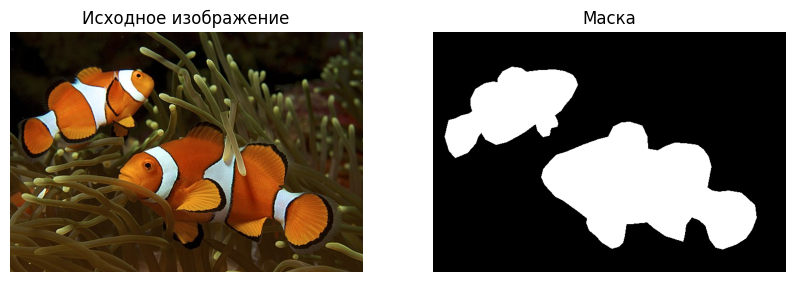

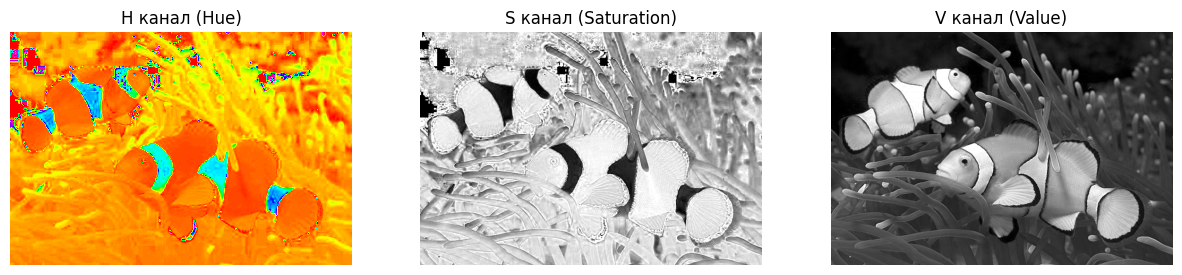

In [6]:
# 4. Пример работы с одним изображением
# Загрузка и визуализация изображения и маски
image_name = 'nemo001.jpg'
image, mask = load_image_and_mask(image_name)

# Визуализируем исходное изображение и его маску
visualize_images_and_masks(image, mask)

# Исследуем цветовые характеристики изображения
explore_color_space(image)

# **Этап 2: Предварительная обработка данных**

In [7]:
# 1. Функция для выделения рыб с акцентом на белые полоски
def create_fish_mask_with_white(image):
    """
    Улучшенная функция для точного выделения рыб с акцентом на белые полоски.
    
    :param image: Входное изображение в формате BGR
    :return: Маска с выделенными рыбами и белыми полосками
    """
    # Преобразуем изображение в HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # 1. Диапазоны для оранжевого цвета (тело рыб)
    light_orange = (5, 100, 100)
    dark_orange = (20, 255, 255)
    
    # 2. Диапазоны для белого цвета (полоски)
    light_white = (0, 0, 180)  # Шире диапазон по насыщенности
    dark_white = (180, 60, 255)
    
    # Создание масок для каждого цвета
    mask_orange = cv2.inRange(img_hsv, light_orange, dark_orange)
    mask_white = cv2.inRange(img_hsv, light_white, dark_white)
    
    # Применение морфологических операций для белых полосок
    kernel_white = np.ones((5, 5), np.uint8)  # Увеличим ядро для белых полосок
    mask_white = cv2.morphologyEx(mask_white, cv2.MORPH_CLOSE, kernel_white)
    
    # Объединение масок
    mask_fish = cv2.bitwise_or(mask_orange, mask_white)
    
    # Морфологическая обработка общей маски
    kernel_fish = np.ones((3, 3), np.uint8)  # Ядро поменьше для общей маски
    mask_fish = cv2.morphologyEx(mask_fish, cv2.MORPH_OPEN, kernel_fish)
    mask_fish = cv2.morphologyEx(mask_fish, cv2.MORPH_CLOSE, kernel_fish)
    
    return mask_fish

In [8]:
# 2. Визуализация маски рыб с акцентом на белые полоски
def visualize_fish_mask_with_white(image, mask):
    # Преобразуем изображение в RGB для корректного отображения
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Настраиваем график
    plt.figure(figsize=(10, 5))
    
    # Отображение исходного изображения
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    # Отображение маски рыб
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Маска рыб с акцентом на белые полоски")
    plt.axis('off')
    
    # Показать график
    plt.show()

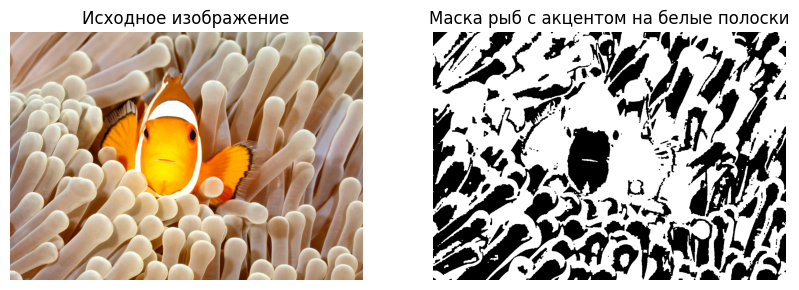

In [9]:
# Пример работы с одним изображением
# Загрузка изображения и создание маски для рыб с акцентом на белые полоски
image_name = 'nemo004.jpg'
image, mask = load_image_and_mask(image_name)

# Создание маски для рыб с точным выделением белых полосок
fish_mask_with_white = create_fish_mask_with_white(image)

# Визуализация полученной маски рыб
visualize_fish_mask_with_white(image, fish_mask_with_white)

# **Этап 2.1: Использование маски для валидации алгоритма сегментации**

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

In [11]:
# 1. Функция для расчета IoU
def calculate_iou(pred_mask, true_mask):
    """
    Функция для расчета метрики IoU (Intersection over Union)
    :param pred_mask: Предсказанная маска (наша сегментация)
    :param true_mask: Истинная маска (ground truth)
    :return: Значение IoU
    """
    # Приводим маски к бинарному виду
    pred_mask_bin = (pred_mask > 0).astype(np.uint8)
    true_mask_bin = (true_mask > 0).astype(np.uint8)
    
    # Рассчитываем IoU
    intersection = np.logical_and(pred_mask_bin, true_mask_bin)
    union = np.logical_or(pred_mask_bin, true_mask_bin)
    
    iou = np.sum(intersection) / np.sum(union)
    
    return iou

In [12]:
# 2. Функция для загрузки истинной маски
def load_true_mask(image_name):
    """
    Загрузка истинной маски для сравнения
    :param image_name: Имя изображения
    :return: Истинная маска
    """
    mask_path = f"dataset/train/masks/{image_name.replace('.jpg', '.png')}"
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return true_mask

In [13]:
# 3. Функция для сегментации с фиксированными порогами в HSV
# Функция для сегментации с учётом жёлтого и уточнёнными порогами для белого цвета
def create_fish_mask_with_yellow_and_fixed_white(image):
    """
    Улучшенная функция для выделения рыб с учётом жёлтого цвета и более точными порогами для белого цвета.
    
    :param image: Входное изображение в формате BGR
    :return: Маска с выделенными рыбами
    """
    # Преобразуем изображение в HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # 1. Диапазоны для оранжевого цвета (тело рыб)
    light_orange = (5, 100, 100)
    dark_orange = (20, 255, 255)
    
    # 2. Диапазоны для жёлтого цвета (рот рыб)
    light_yellow = (20, 100, 100)
    dark_yellow = (30, 255, 255)
    
    # 3. Диапазоны для белого цвета (полоски), суженные для избегания бежевых оттенков
    light_white = (0, 0, 200)  # Увеличиваем минимальный порог яркости
    dark_white = (180, 40, 255)  # Понижаем порог насыщенности
    
    # Создание масок для каждого цвета
    mask_orange = cv2.inRange(img_hsv, light_orange, dark_orange)
    mask_yellow = cv2.inRange(img_hsv, light_yellow, dark_yellow)
    mask_white = cv2.inRange(img_hsv, light_white, dark_white)
    
    # Объединение масок
    mask_fish = cv2.bitwise_or(mask_orange, mask_yellow)
    mask_fish = cv2.bitwise_or(mask_fish, mask_white)
    
    # Применение морфологических операций для улучшения маски
    kernel = np.ones((3, 3), np.uint8)  # Размер ядра для морфологических операций
    mask_fish = cv2.morphologyEx(mask_fish, cv2.MORPH_CLOSE, kernel)  # Закрытие для удаления дырок
    
    return mask_fish

In [14]:
# 4. Функция для валидации сегментации
def validate_segmentation(image_name, algorithm_mask):
    """
    Валидация сегментации путем расчета IoU с истинной маской
    :param image_name: Имя изображения
    :param algorithm_mask: Маска, полученная алгоритмом
    :return: Значение IoU
    """
    # Загрузка истинной маски
    true_mask = load_true_mask(image_name)
    
    # Расчет IoU
    iou = calculate_iou(algorithm_mask, true_mask)
    
    return iou

In [15]:
# 5. Функция для визуализации
def visualize_segmentation(image, algorithm_mask, true_mask, iou_score):
    """
    Визуализация результата сегментации и сравнение с истинной маской
    :param image: Исходное изображение
    :param algorithm_mask: Маска, полученная алгоритмом
    :param true_mask: Истинная маска
    :param iou_score: Значение IoU
    """
    # Преобразуем изображение в RGB для корректного отображения
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Настраиваем график
    plt.figure(figsize=(15, 5))
    
    # Отображение исходного изображения
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Исходное изображение")
    plt.axis('off')
    
    # Отображение маски, полученной алгоритмом
    plt.subplot(1, 3, 2)
    plt.imshow(algorithm_mask, cmap='gray')
    plt.title("Маска (алгоритм)")
    plt.axis('off')
    
    # Отображение истинной маски
    plt.subplot(1, 3, 3)
    plt.imshow(true_mask, cmap='gray')
    plt.title(f"Истинная маска\nIoU: {iou_score:.3f}")
    plt.axis('off')
    
    # Показать график
    plt.show()

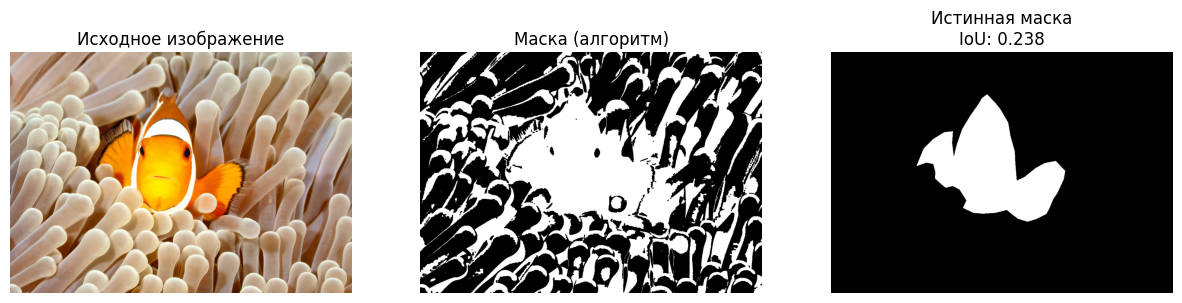

In [17]:
# Пример работы с одним изображением
image_name = 'nemo004.jpg'
image, algorithm_mask = load_image_and_mask(image_name)

# Создание маски для рыб с учётом жёлтого и уточнёнными порогами для белого
fish_mask_with_yellow_and_fixed_white = create_fish_mask_with_yellow_and_fixed_white(image)

# Валидация сегментации
iou_score = validate_segmentation(image_name, fish_mask_with_yellow_and_fixed_white)

# Загрузка истинной маски для визуализации
true_mask = load_true_mask(image_name)

# Визуализация результата
visualize_segmentation(image, fish_mask_with_yellow_and_fixed_white, true_mask, iou_score)

# **Этап 2.2: Разработатка модели машинного обучения**

In [31]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Параметры данных
IMAGE_SIZE = (128, 128)  # Размер, к которому приведём изображения
DATA_PATH = "dataset/train/imgs"
MASK_PATH = "dataset/train/masks"

In [ ]:
# 1. Функция для загрузки изображений и масок
def load_data(image_size=IMAGE_SIZE):
    images = []
    masks = []
    
    # Загрузка изображений
    for image_name in os.listdir(DATA_PATH):
        if image_name.endswith('.jpg'):
            # Загрузка и изменение размера изображения
            image_path = os.path.join(DATA_PATH, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            images.append(image)
            
            # Загрузка и изменение размера маски
            mask_path = os.path.join(MASK_PATH, image_name.replace('.jpg', '.png'))
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, image_size)
            # Преобразуем маску в бинарное изображение (0 и 1)
            mask = (mask > 0).astype(np.uint8)
            masks.append(mask)
    
    # Преобразуем списки в numpy массивы
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

In [ ]:
# 2. Разделение данных на обучающую и валидационную выборки
def prepare_data():
    images, masks = load_data()
    # Нормализуем изображения
    images = images / 255.0
    masks = masks.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Добавляем канал для масок
    
    # Разделение на обучающую и валидационную выборки
    x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [ ]:
# Пример подготовки данных
x_train, x_val, y_train, y_val = prepare_data()

In [ ]:
# Проверим размеры данных
print(f"Размер обучающей выборки: {x_train.shape}, {y_train.shape}")
print(f"Размер валидационной выборки: {x_val.shape}, {y_val.shape}")

In [ ]:
# Функция для создания модели U-Net
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder (down-sampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder (up-sampling)
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Создание модели
model = unet_model()

In [ ]:
# Вывод структуры модели
model.summary()

In [ ]:
# Обучение модели
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(x_val, y_val)
)

In [ ]:
# Сохранение модели
model.save('unet_fish_segmentation.h5')

In [ ]:
# Визуализация графиков обучения
import matplotlib.pyplot as plt

# Построим график потерь
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('График потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

# Построим график точности
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('График точности')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()